# 03 - Apriori, Association Rule Generation, and Results

This notebook loads the transaction matrix, runs Apriori to generate frequent itemsets,
derives association rules, filters them, visualizes, and saves the top rules. It contains
guidance for parameter tuning and interpretation.

### Load Transaction Matrix

In [4]:
import pickle
from pathlib import Path
import pandas as pd

TRAN_PKL = Path("../data/processed/transactions.pkl")
with open(TRAN_PKL, "rb") as f:
    obj = pickle.load(f)
transaction_df = obj['transaction_df']
vocab = obj.get('vectorizer_vocab', transaction_df.columns.tolist())
print("Loaded transaction matrix:", transaction_df.shape)

Loaded transaction matrix: (42891, 1000)


### Run Apriori (Tunable)

In [8]:
%pip install mlxtend

from mlxtend.frequent_patterns import apriori, association_rules

# Parameters — adjust as needed
min_support = 0.10   # Increased to 10% to significantly reduce memory usage
min_confidence = 0.6
min_lift = 1.2
max_itemset_len = 2   # Keep at 2-itemsets only

print("Running apriori with min_support =", min_support, "and max_itemset_len =", max_itemset_len)
# limit max_len to prevent creating a huge number of itemsets/rules that exhaust memory
frequent_itemsets = apriori(transaction_df, min_support=min_support, use_colnames=True, max_len=max_itemset_len, verbose=1)
print("Found frequent itemsets:", frequent_itemsets.shape[0])
if frequent_itemsets.shape[0] > 100000:
	print("Warning: very large number of itemsets ({}). Increase min_support or lower max_itemset_len.".format(frequent_itemsets.shape[0]))
display(frequent_itemsets.sort_values('support', ascending=False).head(20))


[notice] A new release of pip available: 22.3 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
c:\Users\jradl\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:175: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


Note: you may need to restart the kernel to use updated packages.
Running apriori with min_support = 0.1 and max_itemset_len = 2
Processing 5852 combinations | Sampling itemset size 2
Found frequent itemsets: 435


,support,itemsets
5,0.522138,(aug)
20,0.293861,(email)
65,0.270243,(time)
45,0.267632,(one)
48,0.264181,(pleas)
24,0.237952,(get)
53,0.228300,(receiv)
74,0.215943,(wed)
15,0.212609,(compani)
39,0.209858,(name)


### Generate Association Rules and Filter

In [9]:
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_confidence)
print("Total rules (conf>=%.2f):" % min_confidence, rules.shape[0])

# Filter by lift and optionally support
rules = rules[(rules['lift'] >= min_lift)]
rules = rules.sort_values(['lift','confidence','support'], ascending=False)
print("Rules after lift>=%.2f filter:" % min_lift, rules.shape[0])

Total rules (conf>=0.60): 503
Rules after lift>=1.20 filter: 503


### Show Top Rules and Save

In [10]:
# Show top 20 rules (format antecedents -> consequents)
def fmt_itemset(s):
    return ', '.join(sorted(list(s)))

top_rules = rules.head(20).copy()
top_rules['antecedents'] = top_rules['antecedents'].apply(fmt_itemset)
top_rules['consequents'] = top_rules['consequents'].apply(fmt_itemset)
display(top_rules[['antecedents','consequents','support','confidence','lift']])

# Save rules to CSV
OUT_RULES = Path("../data/processed/top_rules.csv")
top_rules.to_csv(OUT_RULES, index=False)
print("Saved top rules to:", OUT_RULES)

,antecedents,consequents,support,confidence,lift
235,cnncom,warner,0.101093,0.999769,9.848670
236,warner,cnncom,0.101093,0.995866,9.848670
50,cnncom,atlanta,0.101093,0.999769,9.739067
51,atlanta,cnncom,0.101093,0.984783,9.739067
80,warner,atlanta,0.101140,0.996325,9.705516
81,atlanta,warner,0.101140,0.985237,9.705516
209,cnncom,georgia,0.101093,0.999769,9.679709
210,georgia,cnncom,0.101093,0.978781,9.679709
308,warner,georgia,0.101093,0.995866,9.641915
307,georgia,warner,0.101093,0.978781,9.641915


Saved top rules to: ..\data\processed\top_rules.csv


### Visualization (Support vs Confidence Scatter Sized by Lift)

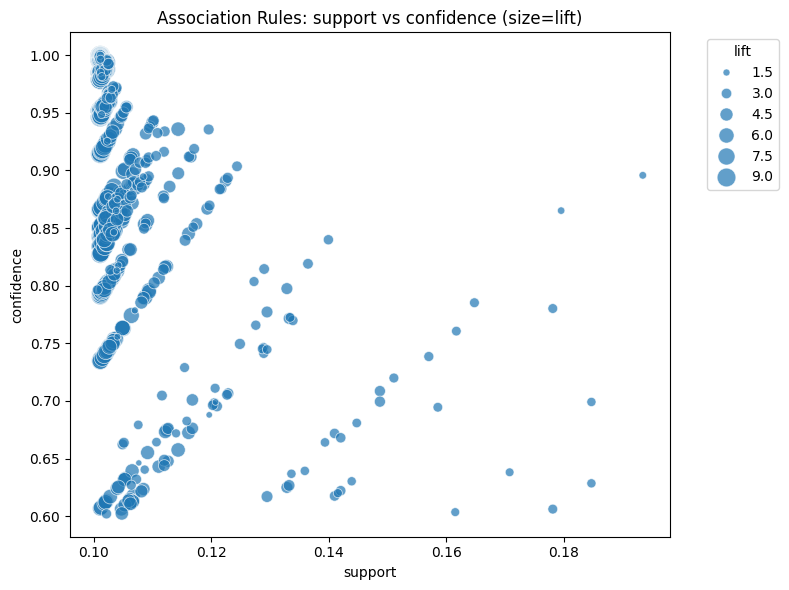

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.scatterplot(data=rules, x='support', y='confidence', size='lift', sizes=(20,200), alpha=0.7)
plt.title('Association Rules: support vs confidence (size=lift)')
plt.xlabel('support')
plt.ylabel('confidence')
plt.legend(title='lift', bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()

### Quick Network of Top-K Rules


[notice] A new release of pip available: 22.3 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


     ---------------------------------------- 2.1/2.1 MB 1.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


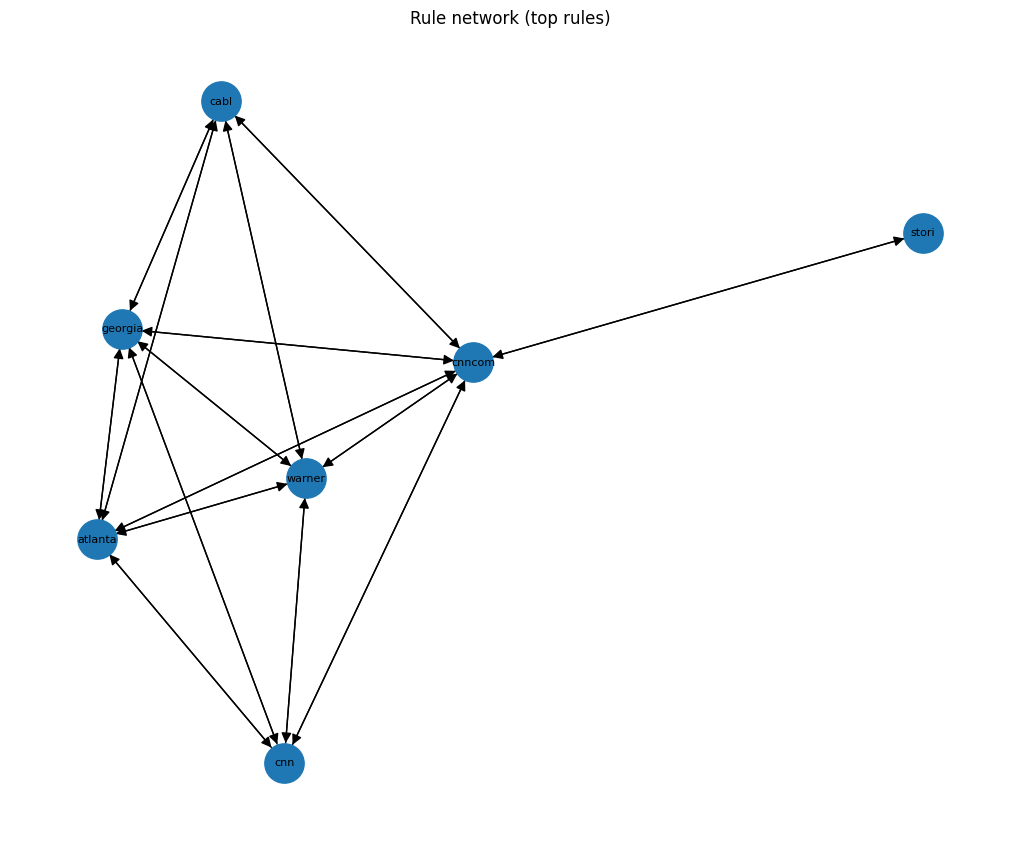

In [13]:
%pip install networkx

# Optional: network visualization of top-K items (requires networkx & matplotlib)
import networkx as nx
try:
    G = nx.DiGraph()
    topk = rules.head(30)
    for _, r in topk.iterrows():
        for a in r['antecedents']:
            for b in r['consequents']:
                G.add_edge(tuple(a) if isinstance(a, (list,set)) else a, 
                           tuple(b) if isinstance(b, (list,set)) else b,
                           weight=r['lift'])
    plt.figure(figsize=(10,8))
    pos = nx.spring_layout(G, k=0.5, seed=42)
    nx.draw(G, pos, with_labels=True, node_size=800, font_size=8, arrowsize=15)
    plt.title('Rule network (top rules)')
    plt.show()
except Exception as e:
    print("Network plot skipped:", e)

## Interpretation

- Focus on high-lift and high-confidence rules. A rule such as `{bank, verify} -> {account}` suggests a common phishing tactic (impersonation of banking/account verification).
- If Apriori produced too few itemsets: reduce `min_support` (try 0.01 or 0.005).